In [16]:
import numpy as np 
import pandas as pd 

import math 
from datetime import date, timedelta, datetime 
import time
import os

from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns

from sklearn.preprocessing import  MinMaxScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import backend

from tensorflow.keras.models import load_model
import joblib

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters


from google.cloud import bigquery
from google.oauth2 import service_account

  
print('Tensorflow Version: ' + tf.__version__)


Tensorflow Version: 2.11.1


# Reference Document

* [https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/](https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/)
* [https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/](https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/)
* [https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/](https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/)
* [https://www.relataly.com/regression-error-metrics-python/923/](https://www.relataly.com/regression-error-metrics-python/923/)
* [https://keras.io/guides/keras_tuner/getting_started/](https://keras.io/guides/keras_tuner/getting_started/)
* [https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Determining the Right Batch Size for a Neural Network to Get Better and Faster Results](https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15#:~:text=Default%20value%20%3D%2032&text=This%20is%20because%20the%20batch,%2C%20256%2C%20512%20and%201024!)

In [18]:
start_date='2015-01-01' 
end_date='2023-05-31'
asset_name='QQQ'   

# univaiate  (single feature)
# prediction_col='EMA1'
# feature_cols=['EMA1']

# multpvaric (nultiple features)
# prediction_col='Close'
# feature_cols=[prediction_col,'EMA1','EMA2','MACD','SIGNAL']

# Load the Data from  BigQuery To Create TrainData as CSV File 

In [19]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df

data_path=f"train_data/{asset_name}_{start_date.replace('-','')}_{end_date.replace('-','')}.csv"

if  os.path.exists(data_path)==False:
    sqlData=f"""
     select * from  `{table_data_id}` where Symbol='{asset_name}' and (Date>='{start_date}' and Date<='{end_date}')
    """
    print(sqlData)
    df=load_data_bq(sqlData)
    df=df.sort_values(by="Date")
    df=df.drop_duplicates(subset=['Date','Symbol'],keep='last')
    df=df.drop(columns=['ImportDateTime'])
    df.to_csv(data_path,index=False)
    print(df.info())
    print("Load Data from BigQuery and Save it as csv.")
else:
    print(f"Load csv {data_path}")

pongthorn.FinAssetForecast.fin_data
Load csv train_data/QQQ_20150101_20230531.csv


# Init Constant Variable

In [20]:
date_col='Date'

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


input_sequence_length =30  #60 #120
output_sequence_length =5  # 10 #20
train_ratio=0.8

n_epochs =100  #50 #100/150/200
n_batch_size = 64  # 16/32/64

n_early=16 

seed=88

#Tuning
mx_step=2 # 2,3,5,10
mxMultipleStep=1  # double trail
nExecutions_per_trial=3 #3  #averger re-run on 1 trail 

min_drop=0.0
max_drop=  0.1 #0.1 0.2  0.5
step_drop=0.1

defaultMaxTrail=10

ratio_traial_max= 1 #0.5 0.7/0.8/1


# Set Tuned-Model Folder

In [21]:
model_path='train_model'
period_str=f"Y{start_date.split('-')[0]}-{end_date.split('-')[0]}"
tune_folder=f'{prediction_col}_{input_sequence_length}To{output_sequence_length}_{asset_name}_E{n_epochs}S{n_early}B{n_batch_size}'
print(tune_folder)

Close_30To5_QQQ_E100S16B64


# Read Train Data

In [22]:
df=pd.read_csv(data_path)
df.drop(columns=['Symbol'],inplace=True)

print(df.tail(input_sequence_length+output_sequence_length+2).reset_index(drop=True)[feature_cols])

df.set_index(date_col,inplace=True)
df=df[feature_cols]
print(df.info())

allCols=list(df.columns)
print(allCols)



     Close      EMA1      EMA2    MACD  SIGNAL
0   317.87  315.4643  311.1299  4.3344  3.5866
1   315.83  315.5308  311.5776  3.9533  3.6324
2   313.04  315.0780  311.7168  3.3611  3.5985
3   319.17  315.8220  312.4267  3.3953  3.5731
4   318.57  316.3216  313.0117  3.3099  3.5402
5   318.84  316.7795  313.5668  3.2127  3.4993
6   318.86  317.1578  314.0709  3.0868  3.4477
7   318.71  317.4400  314.5127  2.9273  3.3827
8   316.28  317.2291  314.6811  2.5480  3.2783
9   316.61  317.1165  314.8648  2.2518  3.1500
10  315.95  316.9044  314.9681  1.9363  2.9983
11  309.99  315.6473  314.4940  1.1532  2.7677
12  311.87  314.9605  314.2441  0.7164  2.5113
13  320.35  315.9404  314.8256  1.1148  2.3367
14  322.56  317.1440  315.5622  1.5817  2.2423
15  322.19  318.0614  316.1934  1.8680  2.1955
16  319.38  318.3012  316.4969  1.8042  2.1466
17  317.29  318.1173  316.5725  1.5449  2.0714
18  316.17  317.7633  316.5341  1.2291  1.9661
19  322.89  318.6954  317.1394  1.5559  1.9148
20  323.69  3

# Exploring the Data

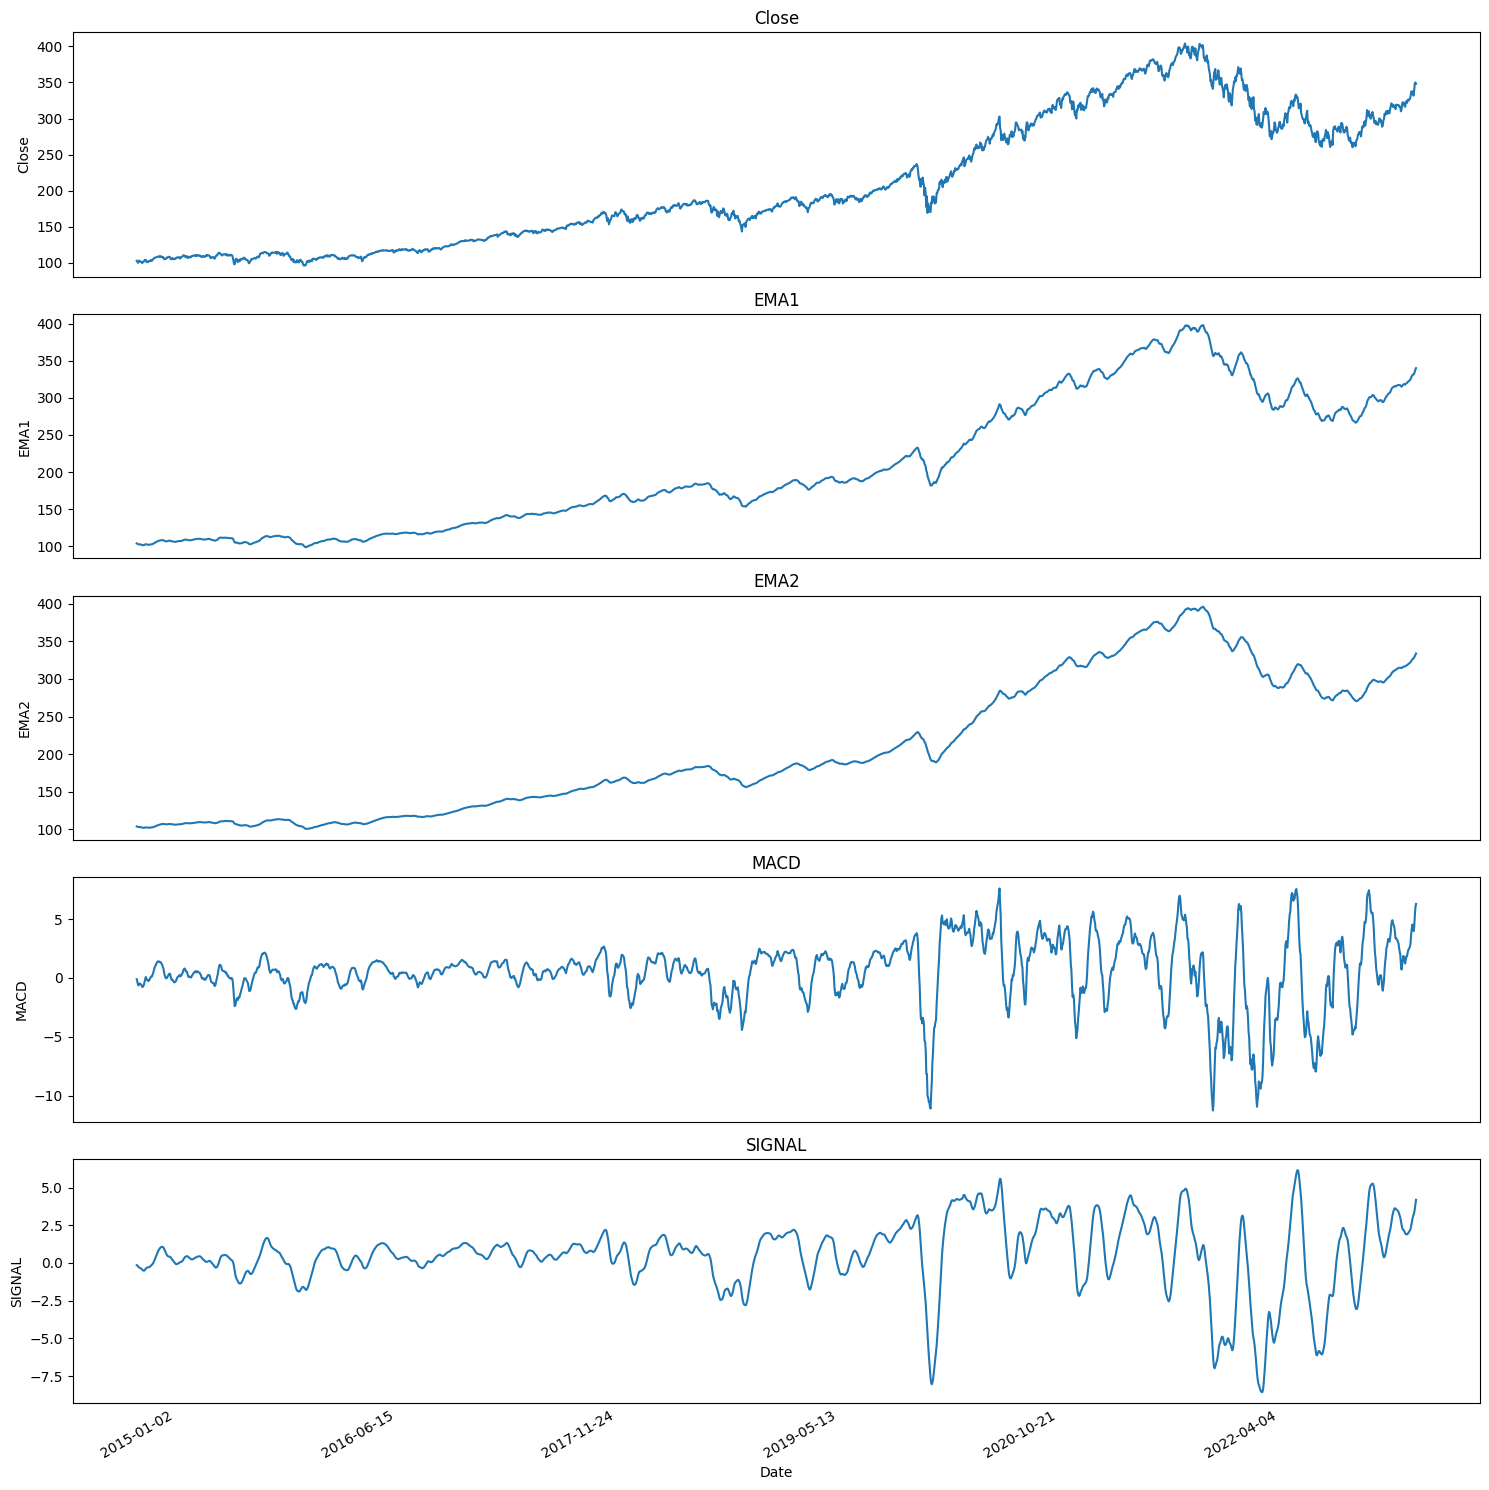

In [23]:
ncols = 1
nrows = len(feature_cols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

In [24]:
# print("Split dataframe to show time-dependent data sequencial sample data point)")
# _dfTrain=df.loc['2015-01-01':'2021-12-31',:]
# print(_dfTrain.shape)  
# print(_dfTrain.head())
# print(_dfTrain.tail())

# print("=========================================================")

# _dfTest=df.loc['2022':,:]
# print(_dfTest.shape)  
# print(_dfTest.head())
# print(_dfTest.tail())

# Get Data Proper To Train Model

In [25]:
def prepare_data(df):

    print("Convert the data to numpy arrays value")
    np_feature_unscaled = np.array(df)
    np_feature_unscaled = np.reshape(np_feature_unscaled, (df.shape[0], -1))
    print(np_feature_unscaled.shape)
    
    np_pred_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_pred_unscaled.shape)
    
    return np_feature_unscaled, np_pred_unscaled

np_feature_unscaled, np_pred_unscaled = prepare_data(df)   


print("Feature Data",np_feature_unscaled.shape)
print(np_feature_unscaled[:3])
print("Prediction Data",np_pred_unscaled.shape)
print(np_pred_unscaled[:3])

Convert the data to numpy arrays value
(2117, 5)
(2117, 1)
Feature Data (2117, 5)
[[102.94   103.8389 103.9428  -0.104   -0.1462]
 [101.43   103.4009 103.7035  -0.3026  -0.1658]
 [100.07   102.7953 103.3575  -0.5622  -0.2153]]
Prediction Data (2117, 1)
[[102.94]
 [101.43]
 [100.07]]


In [26]:
print(f"{input_sequence_length} = How far back the model looks back during training to forecast).")
print(f"{output_sequence_length} = How far into the future the model forecasts the target value")

#How much ratio to split
index_Prediction = df.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Prediction}")



30 = How far back the model looks back during training to forecast).
5 = How far into the future the model forecasts the target value
Prediction Index = 0


In [27]:
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_feature_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

0.8 = 1694 Split the training data into train and train data sets


Target value column data disttribution


<Axes: ylabel='Frequency'>

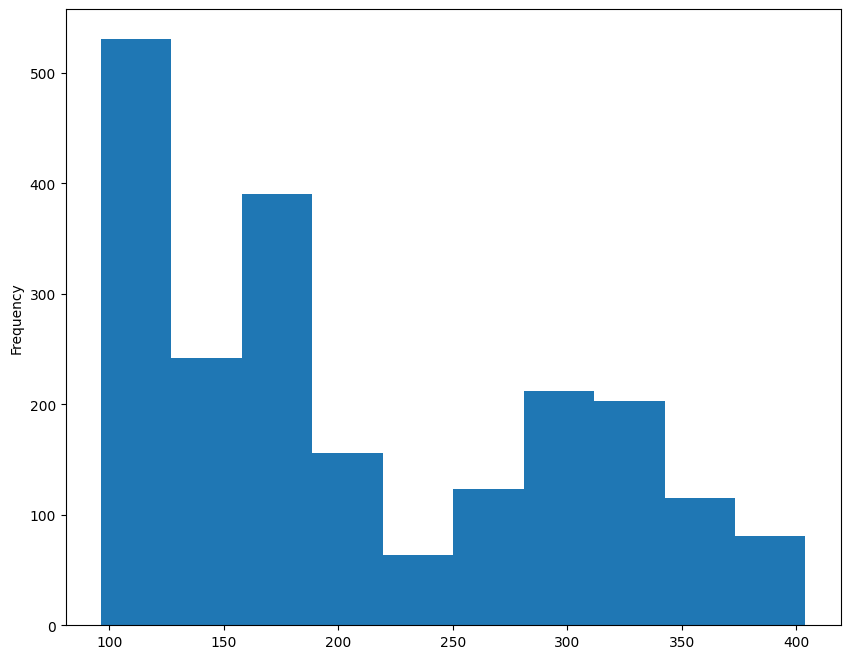

In [28]:
print("Target value column data disttribution")
df[prediction_col].plot.hist(figsize=(10, 8))


In [29]:
print("Scale feature and prediction to a range Max-Min between 0 and 1")
scaler_train = MinMaxScaler()
scaler_pred = MinMaxScaler()


print("Split data and apply only train to scale")

train_data = np_feature_unscaled[0:train_data_length, :]
test_data = np_feature_unscaled[train_data_length - input_sequence_length:, :]

np_PredictVal_unScaled=np_pred_unscaled[0:train_data_length]

print("Train Data to be scaled(feature and prediction)") 
print(train_data.shape,np_PredictVal_unScaled.shape)
print(train_data[:5])
print(np_PredictVal_unScaled[:5])

train_data=scaler_train.fit_transform(train_data)
test_data=scaler_train.transform(test_data)

print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
np_scaled=scaler_train.transform(np_feature_unscaled)
np_scaled_prediction = scaler_pred.fit_transform(np_PredictVal_unScaled)

print("==============Scaler Object For Features=================")  
print(f"{scaler_train.n_features_in_} features are scaled in range 0-1 such as {feature_cols}")
print(f"Max:{scaler_train.data_max_} -  Min:{scaler_train.data_min_}")

print("==============Scaler Object For Prediction Target Value=================")  
print(f"{scaler_pred.n_features_in_} pred col is scaled in range 0-1 such as {prediction_col}")
print(f"Max:{scaler_pred.data_max_} -  Min:{scaler_pred.data_min_}")


print("=========================================")       
print("Scaled data completely")
print("Scaled train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:5])
print(test_data[:5])

print("=========================================")  
print("Scale Prediction data (Scaled from Train data)")
print(np_scaled_prediction.shape)
print(np_scaled_prediction[:5])



Scale feature and prediction to a range Max-Min between 0 and 1
Split data and apply only train to scale
Train Data to be scaled(feature and prediction)
(1694, 5) (1694, 1)
[[102.94   103.8389 103.9428  -0.104   -0.1462]
 [101.43   103.4009 103.7035  -0.3026  -0.1658]
 [100.07   102.7953 103.3575  -0.5622  -0.2153]
 [101.36   102.5343 103.1672  -0.6329  -0.2675]
 [103.3    102.6735 103.1799  -0.5063  -0.2974]]
[[102.94]
 [101.43]
 [100.07]
 [101.36]
 [103.3 ]]
For predict test that take the past 30 train value to predict the first test value
==============Scaler Object For Features=================
5 features are scaled in range 0-1 such as ['Close', 'EMA1', 'EMA2', 'MACD', 'SIGNAL']
Max:[382.11   378.776  376.0118   7.6042   5.5866] -  Min:[ 96.32    98.7107 100.6653 -11.0952  -8.0469]
==============Scaler Object For Prediction Target Value=================
1 pred col is scaled in range 0-1 such as Close
Max:[382.11] -  Min:[96.32]
Scaled data completely
Scaled train and test data
(16

# Creating the Input data  as 3 dimension array (samples, time steps, features]

In [15]:
print("The LSTM RNN needs data with the format of [sample rows, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:])
        y.append(data[i:i + output_sequence_length, index_Prediction]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The LSTM RNN needs data with the format of [sample rows, time steps, features]


In [16]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(f"Use {prediction_col} samples over the past {input_sequence_length} days to predict the future over the next {output_sequence_length} days")
print(x_train[-1:],y_train[-1:])

Here, we create 1694 samples, input_sequence_length time steps per sample, and features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1659, 30, 1) (1659, 5)
(418, 30, 1) (418, 5)
Use EMA1 samples over the past 30 days to predict the future over the next 5 days
[[[0.9514656 ]
  [0.9543785 ]
  [0.95570997]
  [0.95724104]
  [0.95726639]
  [0.95687827]
  [0.95741779]
  [0.95869642]
  [0.95984686]
  [0.95867785]
  [0.95543646]
  [0.95392039]
  [0.95512725]
  [0.95968547]
  [0.96415515]
  [0.96809101]
  [0.96976634]
  [0.97348725]
  [0.97927126]
  [0.98380235]
  [0.98791853]
  [0.9911692 ]
  [0.99458876]
  [0.99773696]
  [0.99944941]
  [1.        ]
  [0.99858105]
  [0.997251  ]
  [0.9954682 ]
  [0.99582097]]] [[0.99627837 0.99374396 0.98639246 0.98066987 0.97820794]]


# Model Training

# Paramterter Network

In [17]:
# Configure the neural network model
# tf.random.set_seed(7)
print("Keras Tuning Parameter Setting")

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]
neuron_number =inputshape_Timestamps * no_feature


step_neuron=int(neuron_number)
max_neuron=int(step_neuron*mx_step)
print(f"Train Row : {x_train.shape[0]}")
print(f"{inputshape_Timestamps}(backward step) x {no_feature}(features) = {neuron_number}, it is total no.NN  to predict future {n_output_neurons} with Hidden Node Unit from {step_neuron} to {max_neuron}")
    


neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=math.ceil(allPosComb*ratio_traial_max)
nMax_trials=nMax_trials*mxMultipleStep

# if nMax_trials<defaultMaxTrail: 
#     nMax_trials=defaultMaxTrail

nMax_trials=nMax_trials*1
print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Keras Tuning Parameter Setting
Train Row : 1659
30(backward step) x 1(features) = 30, it is total no.NN  to predict future 5 with Hidden Node Unit from 30 to 60
[30, 60] and [0.  0.1]
all combination : 2 x 2 = 4
MAx run : 4 each trail run to essemble  3


# NetWork Architeture Model Design

In [18]:
def build_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop))) 
    
    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric])
    return model

# Start Tuning 

In [19]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

220623_1925
Start tund at 2023-06-22 19:25:41.049533


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_model_way,
        objective=main_obj_metric,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])



Trial 4 Complete [00h 07m 26s]
mean_absolute_error: 0.008121746592223644

Best mean_absolute_error So Far: 0.008121746592223644
Total elapsed time: 00h 41m 18s
INFO:tensorflow:Oracle triggered exit


In [21]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

Space to search
Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 60, 'step': 30, 'sampling': 'linear'}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.1, 'sampling': 'linear'}
Suumary of 4
Results summary
Results in tuning/EMA1_30To5_QQQ_E100S16B64/220623_1925
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 3 summary
Hyperparameters:
input_unit: 60
Dropout_rate: 0.0
Score: 0.008121746592223644

Trial 0 summary
Hyperparameters:
input_unit: 30
Dropout_rate: 0.0
Score: 0.009168611218531927

Trial 2 summary
Hyperparameters:
input_unit: 60
Dropout_rate: 0.1
Score: 0.01427484272668759

Trial 1 summary
Hyperparameters:
input_unit: 30
Dropout_rate: 0.1
Score: 0.015390296466648579


In [22]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.69
2023-06-22 20:07:00.369209


# Get Optimal HyperParamters

In [41]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print("build model from  the best tuning")

# model=tuner.get_best_models(num_models=1)[0]

model = tuner.hypermodel.build(best_hps)
print(model.summary())

{'input_unit': 60, 'Dropout_rate': 0.0}
build model from  the best tuning
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60)                14880     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 305       
                                                                 
Total params: 15,185
Trainable params: 15,185
Non-trainable params: 0
_________________________________________________________________
None


# Training the TUNED Model 

In [43]:
print(f"Training the Best Model with early stop at {n_early}")
t_Start=time.time()
print(datetime.now())


early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)
history = model.fit(x_train, y_train, 
                batch_size=n_batch_size, 
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2, callbacks=[early_stop]
               )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the Best Model with early stop at 16
2023-06-22 21:09:16.747601
Epoch 1/100
26/26 - 1s - loss: 0.0182 - mean_absolute_error: 0.0182 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - 868ms/epoch - 33ms/step
Epoch 2/100
26/26 - 1s - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296 - 957ms/epoch - 37ms/step
Epoch 3/100
26/26 - 1s - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521 - 863ms/epoch - 33ms/step
Epoch 4/100
26/26 - 1s - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212 - 920ms/epoch - 35ms/step
Epoch 5/100
26/26 - 1s - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197 - 852ms/epoch - 33ms/step
Epoch 6/100
26/26 - 1s - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214 - 1s/epoch - 39ms/step
Epoch 7/100
26/26 - 1s - loss: 0.0137 - mean_abs

In [45]:
val_per_epoch = history.history[main_obj_metric]
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 89


In [46]:
print("List Metrics")
for key in history.history.keys():
    print(key)
print("=====================================================")    
# Evaluate the model on the test data using `evaluate`
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=n_batch_size)
print("test loss, test acc:", results)

List Metrics
loss
mean_absolute_error
val_loss
val_mean_absolute_error
Evaluate on test data
7/7 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_absolute_error: 0.0332
test loss, test acc: [0.03323867544531822, 0.03323867544531822]


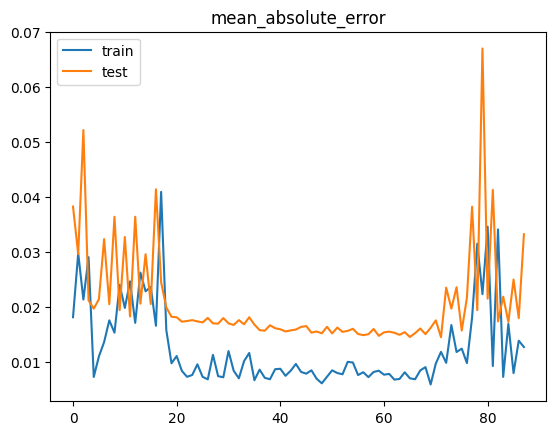

In [47]:
plt.title(main_obj_metric)
plt.plot(history.history[main_obj_metric], label='train')
plt.plot(history.history[f'val_{main_obj_metric}'], label='test')
plt.legend()
plt.show()

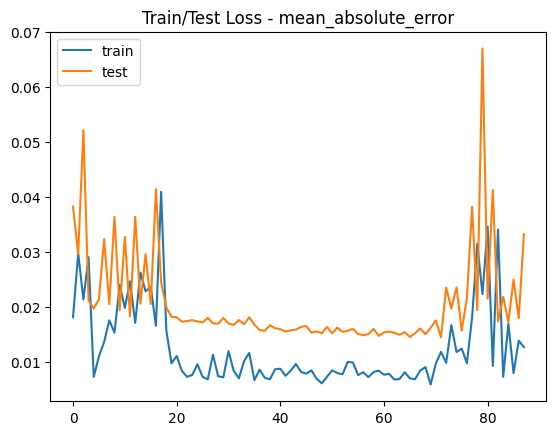

In [48]:
plt.title(f"Train/Test Loss - {main_loss}")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step #5 Evaluate Model Performance

In [50]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
# print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

14/14 [==============================] - 1s 7ms/step
(418, 5)
(418, 5)


In [51]:
dfTestActual=pd.DataFrame(data=y_test_unscaled, \
                          columns=[ f"Step{x}-{prediction_col}"  for x in range(1,output_sequence_length+1,1)])
dfTestPred=pd.DataFrame(data=y_pred, \
                          columns=[ f"Step{x}-Pred-{prediction_col}"  for x in range(1,output_sequence_length+1,1)]) 
dfActualPred=pd.concat([dfTestActual,dfTestPred],axis=1)
ActualPredcols=sorted(dfActualPred.columns.tolist())
dfActualPred=dfActualPred[ActualPredcols]
dfActualPred.head(3)

,Step1-EMA1,Step1-Pred-EMA1,Step2-EMA1,Step2-Pred-EMA1,Step3-EMA1,Step3-Pred-EMA1,Step4-EMA1,Step4-Pred-EMA1,Step5-EMA1,Step5-Pred-EMA1
0,372.8380,376.415192,372.3856,378.339508,370.1100,380.586945,368.1409,378.715851,366.2899,380.988037
1,372.3856,376.153473,370.1100,378.262207,368.1409,380.418793,366.2899,378.589996,365.1790,380.793274
2,370.1100,376.134766,368.1409,378.315155,366.2899,380.419952,365.1790,378.635468,362.8955,380.769592


In [61]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
print("===========================================================================")

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


# Root Mean  Squre Error
# RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
# print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')


Mean Absolute Error (MAE): 9.31
Mean Absolute Percentage Error (MAPE): 2.99 %


# Plot Multiple Forcast (Most Complex Step)

In [62]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Prediction])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = f"{asset_name}-{prediction_col}")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



# Step #6 Create a new Forecast

In [63]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

x_test_latest_batch

(1, 30, 1) is the latest input batch from the test dataset, which is contains the price values for the last 30 trading days


array([[[0.77998631],
        [0.78099393],
        [0.78024089],
        [0.77983884],
        [0.77908152],
        [0.77459293],
        [0.77214064],
        [0.77563947],
        [0.77993704],
        [0.7832127 ],
        [0.78406893],
        [0.7834123 ],
        [0.78214831],
        [0.78547646],
        [0.78871892],
        [0.79004111],
        [0.79339497],
        [0.79682703],
        [0.79887583],
        [0.80169446],
        [0.80424101],
        [0.80889528],
        [0.81669596],
        [0.82258495],
        [0.82813687],
        [0.82990074],
        [0.83023352],
        [0.83574509],
        [0.84588951],
        [0.85521519]]])

In [65]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 74ms/step
Predict on the inverse transformed batch (1, 5)
[[342.66608 344.87576 346.6229  345.12662 347.2913 ]]


In [66]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (30, 1)
Y-Test= (5, 1)


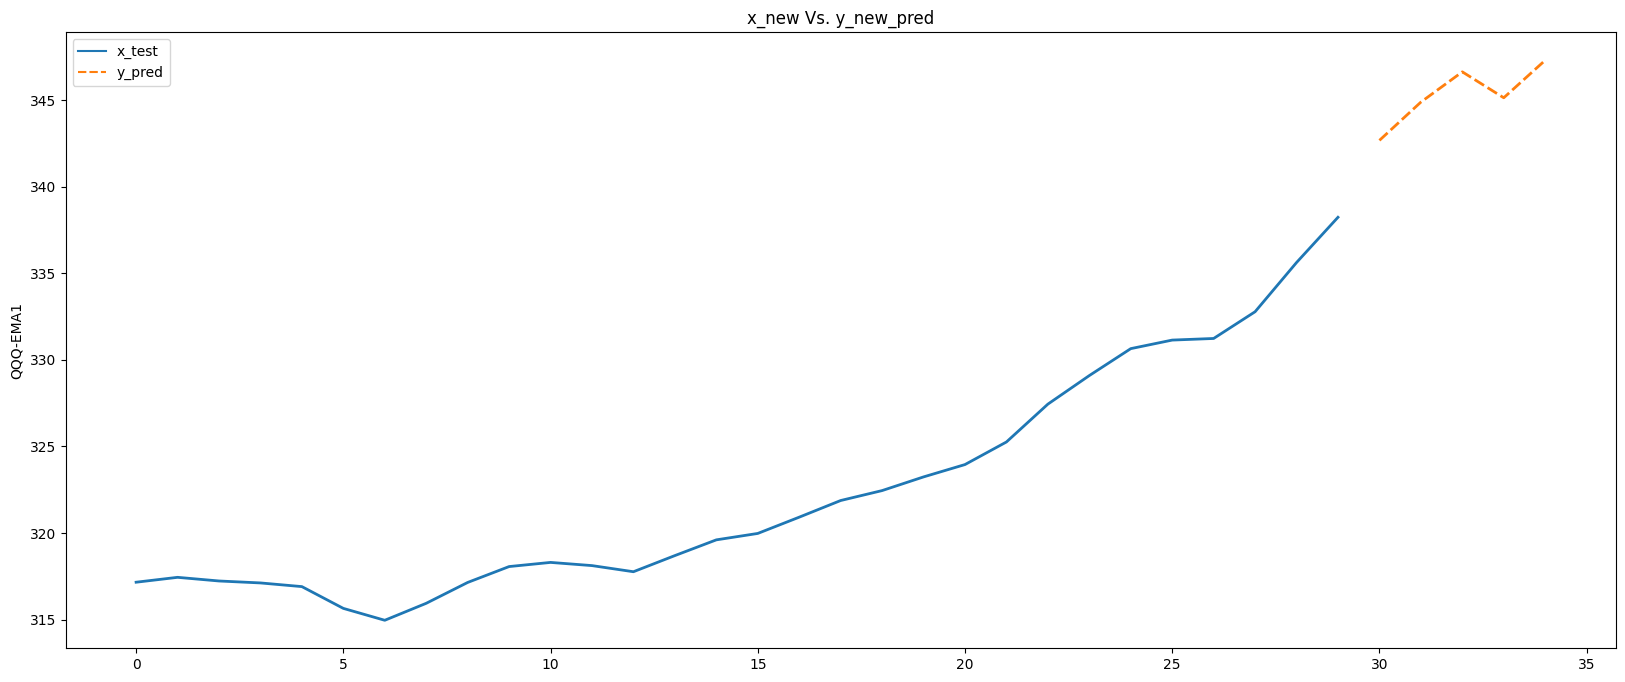

In [58]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")

#### 

# Create Final Model

In [68]:
dfAll=df.sort_values(by=[date_col]).copy()
npAll_unscaled, npPredictCol_unscaled = prepare_data(dfAll) 
print(npAll_unscaled.shape,npPredictCol_unscaled.shape)

Convert the data to numpy arrays value
(2117, 1)
(2117, 1)
(2117, 1) (2117, 1)


In [69]:
scalerFinalTrain = MinMaxScaler()
scalerFinalPred = MinMaxScaler()
npAll_scaled = scalerFinalTrain.fit_transform(npAll_unscaled)
npAllPredictCol_scaled = scalerFinalPred.fit_transform(npPredictCol_unscaled)
print(npAll_scaled.shape,npAllPredictCol_scaled.shape)
print(npAll_scaled[:2])
print(npAllPredictCol_scaled[:2])

(2117, 1) (2117, 1)
[[0.01713827]
 [0.01567449]]
[[0.01713827]
 [0.01567449]]


In [70]:
x_all, y_all = partition_dataset(input_sequence_length, output_sequence_length,npAll_scaled)
print(f"We will tranin {x_all.shape},{y_all.shape} with batch={n_batch_size} and best epoch={best_epoch}")

We will tranin (2082, 30, 1),(2082, 5) with batch=64 and best epoch=89


In [71]:
print(f"Training All")
t_Start=time.time()
print(datetime.now())

history_final=model.fit(x=x_all, y=y_all, batch_size=n_batch_size, epochs=best_epoch,shuffle=False)
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training All
2023-06-22 23:14:21.904872
Epoch 1/89
33/33 [==============================] - 1s 27ms/step - loss: 0.0208 - mean_absolute_error: 0.0208
Epoch 2/89
33/33 [==============================] - 1s 34ms/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 3/89
33/33 [==============================] - 1s 37ms/step - loss: 0.0127 - mean_absolute_error: 0.0127
Epoch 4/89
33/33 [==============================] - 1s 35ms/step - loss: 0.0116 - mean_absolute_error: 0.0116
Epoch 5/89
33/33 [==============================] - 1s 35ms/step - loss: 0.0102 - mean_absolute_error: 0.0102
Epoch 6/89
33/33 [==============================] - 1s 43ms/step - loss: 0.0119 - mean_absolute_error: 0.0119
Epoch 7/89
33/33 [==============================] - 1s 36ms/step - loss: 0.0207 - mean_absolute_error: 0.0207
Epoch 8/89
33/33 [==============================] - 1s 39ms/step - loss: 0.0152 - mean_absolute_error: 0.0152
Epoch 9/89
33/33 [==============================] - 1s 38ms/step - loss: 0.0110 

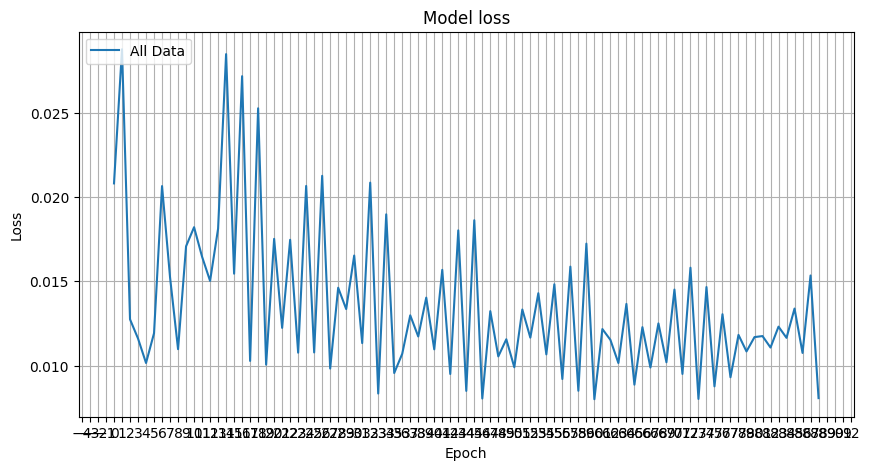

In [72]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history_final.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["All Data"], loc="upper left")
plt.grid()
plt.show()

In [73]:
print("Save model and scaler")
modelName=f"{tune_folder}-{period_str}"
#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}_ma.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)

joblib.dump(scalerFinalTrain,file_scaler)
joblib.dump(scalerFinalPred ,file_scaler_pred)

Save model and scaler


['train_model/scaler_pred_EMA1_30To5_QQQ_E100S16B64-Y2015-2023.gz']